In [1]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

Loading the dataset

In [5]:
sm = pd.read_csv('/content/IMDB Dataset.csv')
sm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
sm.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
sm.shape

(50000, 2)

In [10]:
print(sm['sentiment'])

0        positive
1        positive
2        positive
3        negative
4        positive
           ...   
49995    positive
49996    negative
49997    negative
49998    negative
49999    negative
Name: sentiment, Length: 50000, dtype: object


In [11]:
sm['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

### Prepare Train Test Split

In [12]:
# build train and test datasets
reviews = sm['review'].values
sentiments = sm['sentiment'].values

train_reviews = reviews[:35000]
train_sentiments = sentiments[:35000]

test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]

# Text Wrangling & Normalization

In [13]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata

In [14]:
def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()
    norm_docs.append(doc)

  return norm_docs

In [15]:
%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

100%|██████████| 15000/15000 [00:10<00:00, 1499.98it/s]

CPU times: user 28 s, sys: 153 ms, total: 28.2 s
Wall time: 29.7 s


## Preprocessing

In [16]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [17]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('dawgis', 175795), ('<PAD>', 0), 1)

In [18]:
train_sequences = t.texts_to_sequences(norm_train_reviews)

In [19]:
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [20]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=175796
Number of Documents=35000


### Sequence Normalization

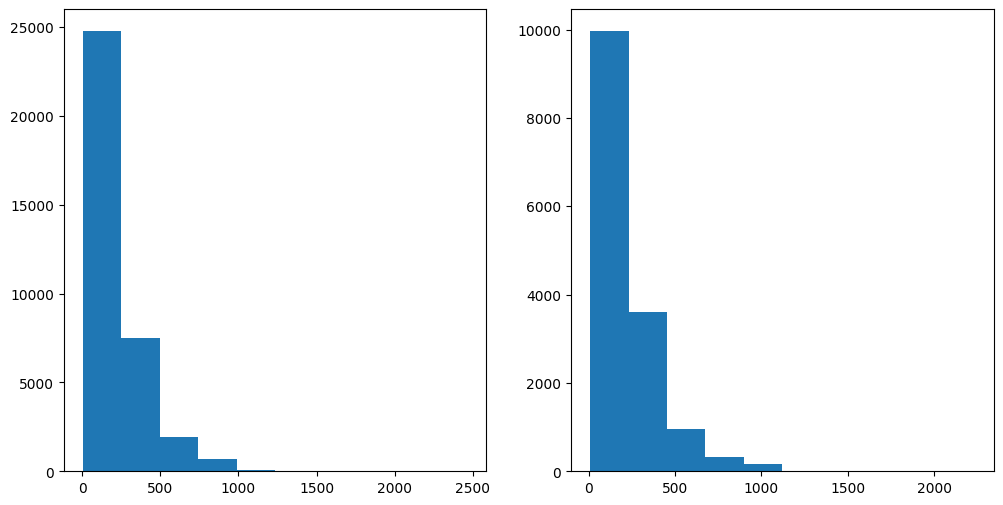

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

### Sequence Normalization

In [22]:
MAX_SEQUENCE_LENGTH = 1000

In [23]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((35000, 1000), (15000, 1000))

### Encoding Labels

In [24]:
le = LabelEncoder()
num_classes= 2

In [25]:
y_train = le.fit_transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [26]:
VOCAB_SIZE = len(t.word_index)

## Prepare the Model

In [28]:
EMBED_SIZE = 300
EPOCHS=5
BATCH_SIZE=128

In [30]:
from tensorflow.keras.layers import Dropout, GlobalMaxPooling1D

# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 1000, 300)      │    52,738,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 1000, 128)      │       153,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 500, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 500, 64)        │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 250, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 250, 32)        │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 125, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     1,024,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,958,097 (205.83 MB)

 Trainable params: 53,958,097 (205.83 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [32]:
# Fit the model
history = model.fit(X_train, y_train,
          validation_split=0.1,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          verbose=1)

Epoch 1/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 950s 4s/step - accuracy: 0.6457 - loss: 0.6366 - val_accuracy: 0.9014 - val_loss: 0.2394
Epoch 2/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 930s 4s/step - accuracy: 0.9547 - loss: 0.1278 - val_accuracy: 0.8980 - val_loss: 0.2556
Epoch 3/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 926s 4s/step - accuracy: 0.9907 - loss: 0.0309 - val_accuracy: 0.8880 - val_loss: 0.4142
Epoch 4/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 1008s 4s/step - accuracy: 0.9986 - loss: 0.0069 - val_accuracy: 0.8883 - val_loss: 0.5255
Epoch 5/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 939s 4s/step - accuracy: 0.9996 - loss: 0.0016 - val_accuracy: 0.8923 - val_loss: 0.6024


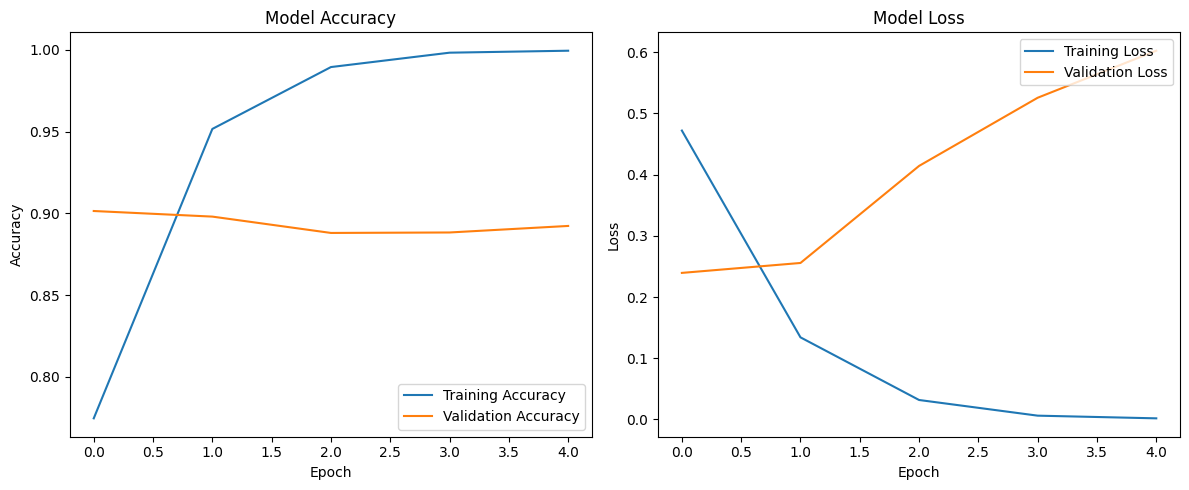

In [33]:
# Assuming 'history' is the output of model.fit
# history = model.fit(X_train, y_train,
#                     validation_split=0.1,
#                     epochs=EPOCHS,
#                     batch_size=BATCH_SIZE,
#                     verbose=1)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [34]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

469/469 ━━━━━━━━━━━━━━━━━━━━ 100s 213ms/step - accuracy: 0.9005 - loss: 0.5554
Accuracy: 89.71%


In [35]:
# Get predictions (probabilities) for each class
probabilities = model.predict(X_test)

# Convert probabilities to binary class predictions
predictions = (probabilities > 0.5).astype(int).ravel()

# Display the first 10 predictions
print(predictions[:10])

469/469 ━━━━━━━━━━━━━━━━━━━━ 108s 230ms/step
[0 1 0 1 1 0 1 1 1 1]


In [36]:
predictions = ['positive' if item == 1 else 'negative' for item in predictions]
predictions[:10]

['negative',
 'positive',
 'negative',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive']

In [37]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

    negative       0.91      0.89      0.90      7490
    positive       0.89      0.91      0.90      7510

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000



,negative,positive
negative,6640,850
positive,694,6816


In [38]:
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Ensure this is imported

# Function to preprocess a single raw text (uses existing utility functions)
def preprocess_single_text(text):
    # Use existing utility functions for preprocessing
    text = strip_html_tags(text)
    text = text.translate(text.maketrans("\n\t\r", "   "))
    text = text.lower()
    text = remove_accented_chars(text)
    text = contractions.fix(text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text, re.I|re.A)  # Remove special characters
    text = re.sub(' +', ' ', text)  # Remove extra spaces
    text = text.strip()
    return text

# Function to predict sentiment for a raw text
def predict_sentiment(raw_text):
    # Preprocess the input text
    norm_text = preprocess_single_text(raw_text)

    # Convert to sequence using the tokenizer
    sequence = t.texts_to_sequences([norm_text])

    # Pad the sequence to the same length as the training data
    padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)  # Corrected this line

    # Predict sentiment probability
    probability = model.predict(padded_sequence)[0][0]
     # Convert probability to a class label
    sentiment = "positive" if probability > 0.5 else "negative"

    return sentiment, probability

# Example usage
new_text = "The plot was really messy and not interesting.. i regret watching the movie."
sentiment, probability = predict_sentiment(new_text)

print(f"Sentiment: {sentiment}")
print(f"Probability: {probability:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Sentiment: negative
Probability: 0.04
